# Libraries Used

In [6]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import datetime as dt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
import scipy.stats as stats
from scipy.stats import skew

## Importing Data

In [8]:
train = pd.read_csv("fraudTrain.csv", index_col=0)
pd.options.display.float_format = '{:,.2f}'.format

# Data Cleansing

In [9]:
train.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0


In [10]:
train.shape

(1296675, 22)

In [11]:
train.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,"1,296,675.00","417,192,042,079,726,656.00","1,308,806,447,000,240,384.00","60,416,207,185.00","180,042,946,491,150.00","3,521,417,320,836,166.00","4,642,255,475,285,942.00","4,992,346,398,065,154,048.00"
amt,"1,296,675.00",70.35,160.32,1.00,9.65,47.52,83.14,"28,948.90"
zip,"1,296,675.00","48,800.67","26,893.22","1,257.00","26,237.00","48,174.00","72,042.00","99,783.00"
lat,"1,296,675.00",38.54,5.08,20.03,34.62,39.35,41.94,66.69
long,"1,296,675.00",-90.23,13.76,-165.67,-96.80,-87.48,-80.16,-67.95
city_pop,"1,296,675.00","88,824.44","301,956.36",23.00,743.00,"2,456.00","20,328.00","2,906,700.00"
unix_time,"1,296,675.00","1,349,243,636.73","12,841,278.42","1,325,376,018.00","1,338,750,742.50","1,349,249,747.00","1,359,385,375.50","1,371,816,817.00"
merch_lat,"1,296,675.00",38.54,5.11,19.03,34.73,39.37,41.96,67.51
merch_long,"1,296,675.00",-90.23,13.77,-166.67,-96.90,-87.44,-80.24,-66.95
is_fraud,"1,296,675.00",0.01,0.08,0.00,0.00,0.00,0.00,1.00


In [13]:
train["amt"].describe()

count   1,296,675.00
mean           70.35
std           160.32
min             1.00
25%             9.65
50%            47.52
75%            83.14
max        28,948.90
Name: amt, dtype: float64

<Axes: >

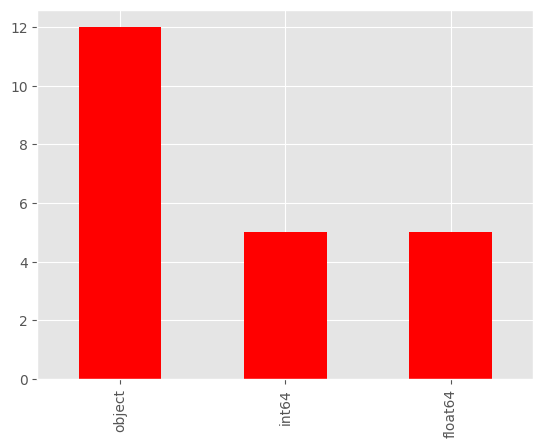

In [15]:
train.dtypes.value_counts().plot(kind='bar', color="red")

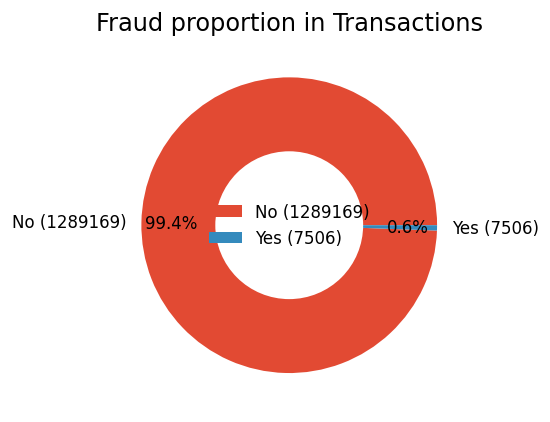

In [86]:
donut = train["is_fraud"].value_counts().reset_index()
donut.columns = ["is_fraud", "count"]

labels = [f"No ({donut.loc[donut['is_fraud'] == 0, 'count'].values[0]})", 
                  f"Yes ({donut.loc[donut['is_fraud'] == 1, 'count'].values[0]})"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["count"],
                labels=labels,
                autopct="%1.1f%%",
                pctdistance=0.8,
                explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud proportion in Transactions")
plt.legend(labels, loc="center", frameon=False)
plt.show()

<Axes: xlabel='amt', ylabel='Density'>

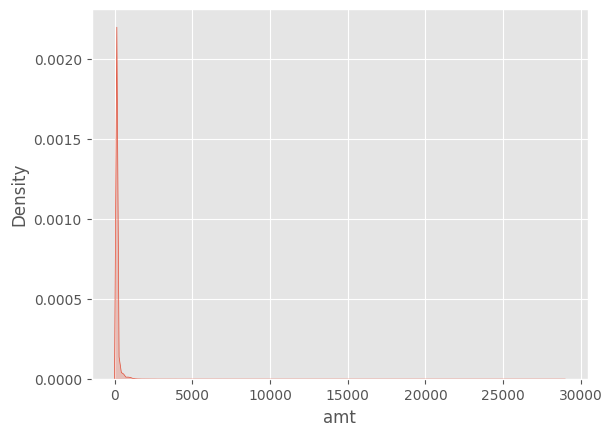

In [23]:
sns.kdeplot(train["amt"], fill=True)

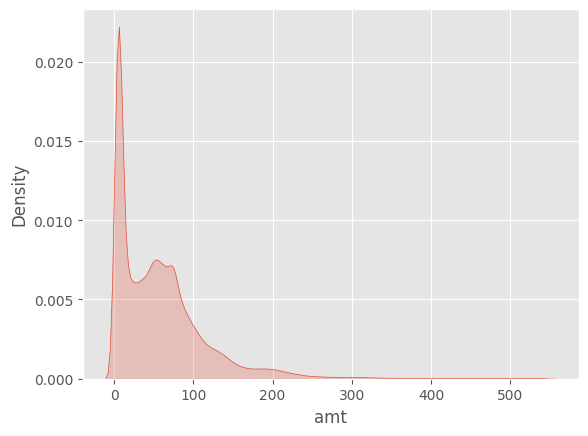

In [24]:
p99 = train["amt"].quantile(0.99)
sns.kdeplot(x="amt", data=train[train["amt"] <= p99], fill=True);

<Axes: xlabel='amt', ylabel='Probability'>

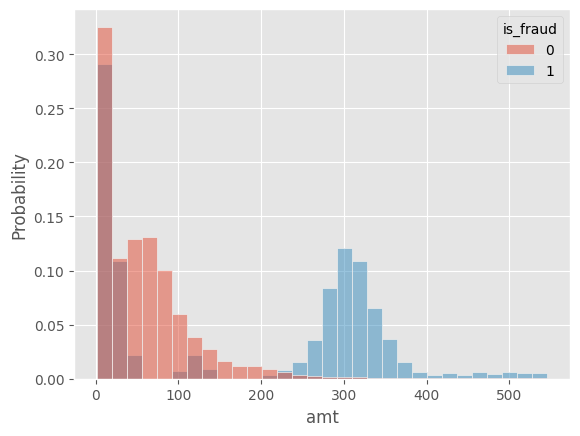

In [25]:
p99 = train["amt"].quantile(0.99)
sns.histplot(x="amt", hue="is_fraud", bins=30,stat="probability", data=train[train["amt"] <= p99],common_norm=False)

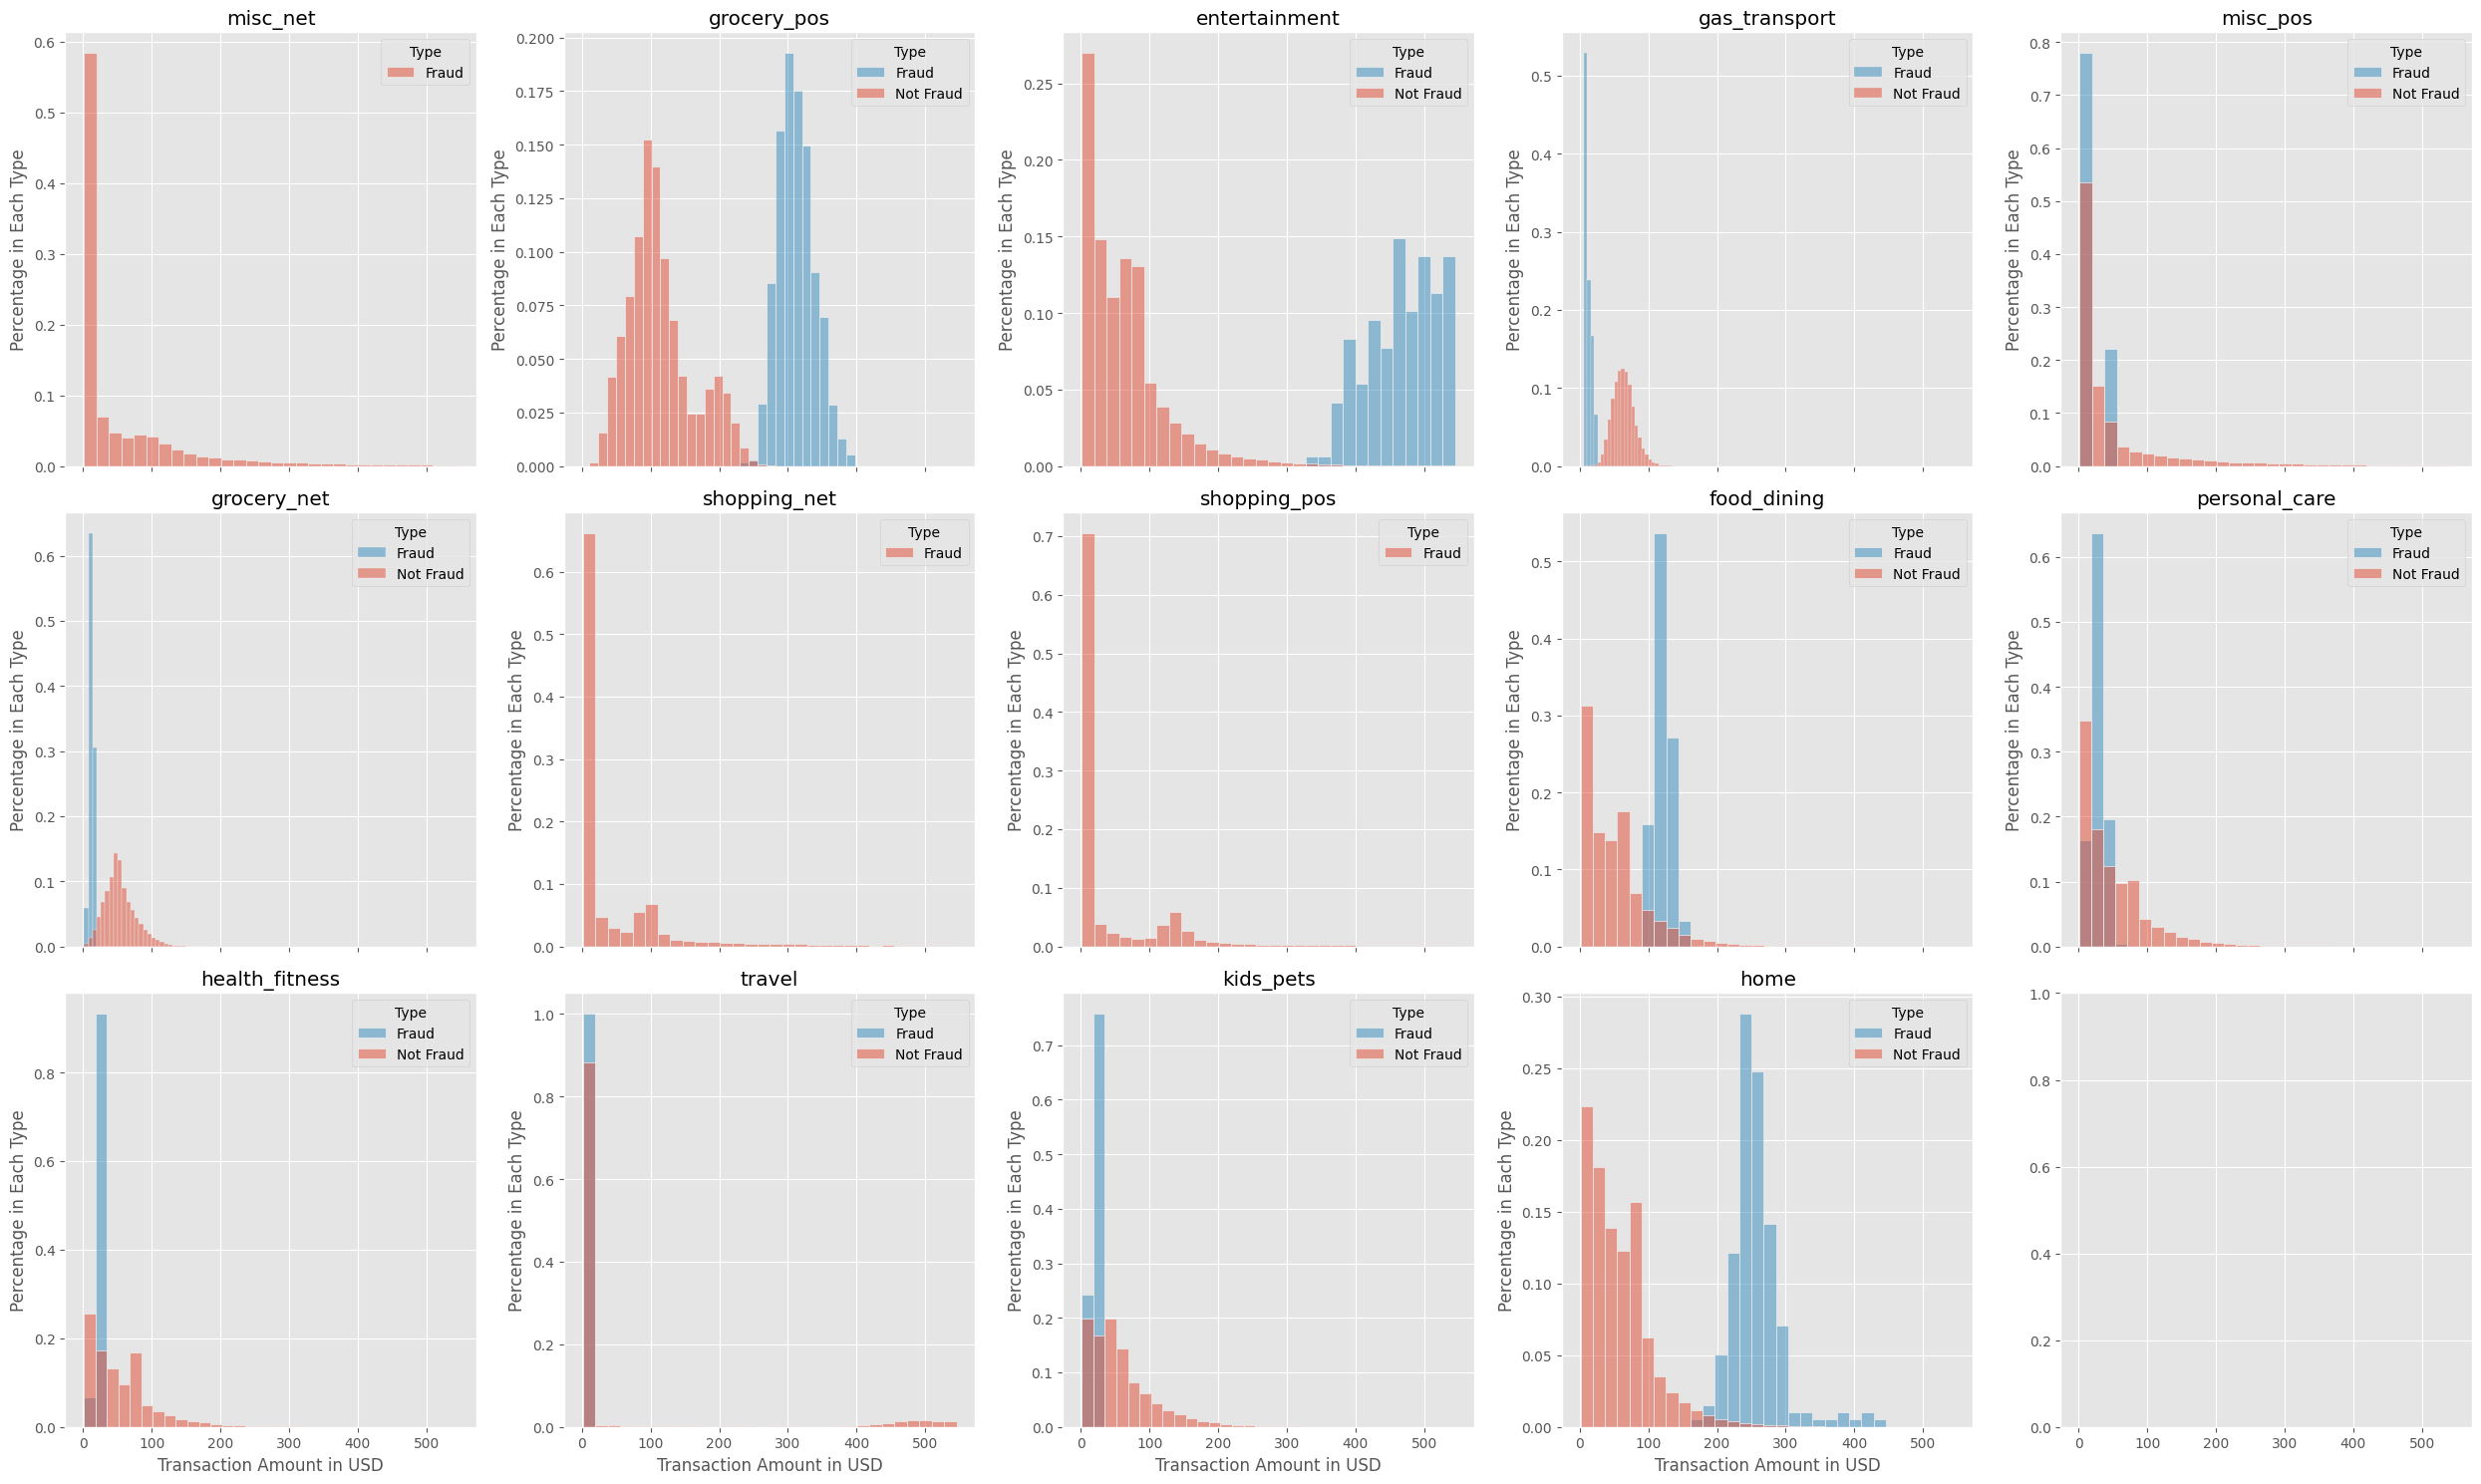

In [26]:
categories = train['category'].unique()

num_plots = len(categories)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)

for i, category in enumerate(categories):

    row = i // num_cols
    col = i % num_cols

    data_category = train[train['category'] == category]

    if num_rows == 1 and num_cols == 1:
        ax = axes
    elif num_rows == 1 or num_cols == 1:
        ax = axes[i]
    else:
        ax = axes[row, col]

    sns.histplot(x='amt', data=data_category[data_category['amt'] <= p99],
                 hue='is_fraud', stat='probability',
                 common_norm=False, bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{category}')
    ax.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.tight_layout()

plt.show()

In [27]:
# non_fraud
non_fraud = train[train['is_fraud'] == 0]['category'].value_counts(
    normalize=True).to_frame().reset_index()
non_fraud.columns = ['category', 'not_fraud_percentual_vs_total']

# fraud
fraud = train[train['is_fraud'] == 1]['category'].value_counts(
    normalize=True).to_frame().reset_index()
fraud.columns = ['category', 'fraud_percentage_vs_total']

# merging two dataframes and calculating "fraud level"
non_fraud_vs_fraud = non_fraud.merge(fraud, on='category')
non_fraud_vs_fraud['fraud_level'] = non_fraud_vs_fraud['fraud_percentage_vs_total'] - \
    non_fraud_vs_fraud['not_fraud_percentual_vs_total']

non_fraud_vs_fraud

,category,not_fraud_percentual_vs_total,fraud_percentage_vs_total,fraud_level
0,gas_transport,0.10,0.08,-0.02
1,home,0.10,0.03,-0.07
2,grocery_pos,0.09,0.23,0.14
3,shopping_pos,0.09,0.11,0.02
4,kids_pets,0.09,0.03,-0.06
5,shopping_net,0.07,0.23,0.15
6,entertainment,0.07,0.03,-0.04
7,food_dining,0.07,0.02,-0.05
8,personal_care,0.07,0.03,-0.04
9,health_fitness,0.07,0.02,-0.05


C:\Users\dodom\AppData\Local\Temp\ipykernel_13224\3942903429.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='category', x='fraud_level',
C:\Users\dodom\AppData\Local\Temp\ipykernel_13224\3942903429.py:2: UserWarning: 
The palette list has fewer values (6) than needed (14) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(y='category', x='fraud_level',


Text(0.5, 1.0, 'Fraud Level')

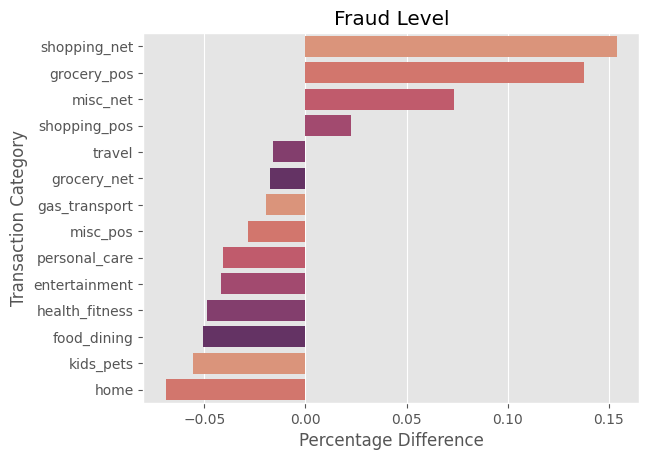

In [29]:
custom_palette = sns.color_palette("flare")
ax = sns.barplot(y='category', x='fraud_level',data=non_fraud_vs_fraud.sort_values('fraud_level', ascending=False), palette=custom_palette)
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('Fraud Level')

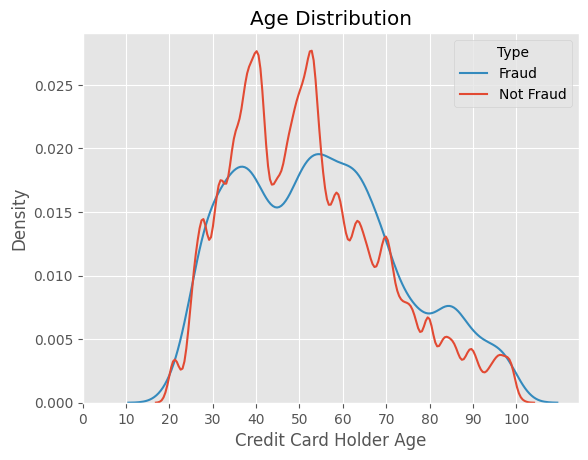

In [30]:
train['age'] = dt.date.today().year-pd.to_datetime(train['dob']).dt.year
ax = sns.kdeplot(x='age', data=train, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0, 110, 10))
plt.title('Age Distribution')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud']);

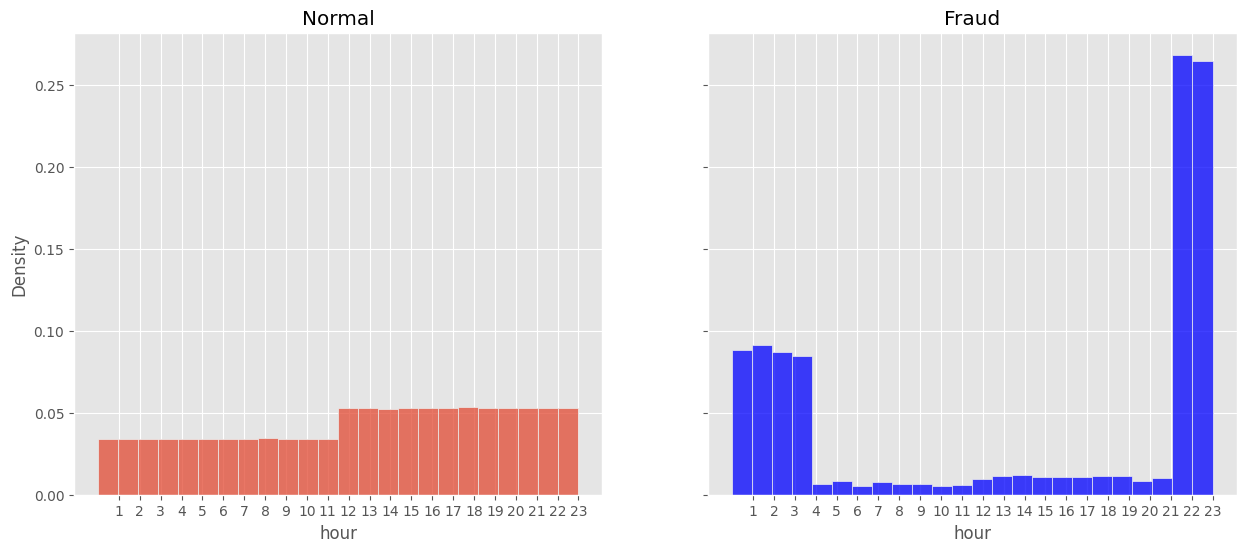

In [31]:
train['hour'] = pd.to_datetime(train['trans_date_trans_time']).dt.hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='hour', data=train[train["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1)
ax2 = sns.histplot(x='hour', data=train[train["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 24))
ax2.set_xticks(np.arange(1, 24))

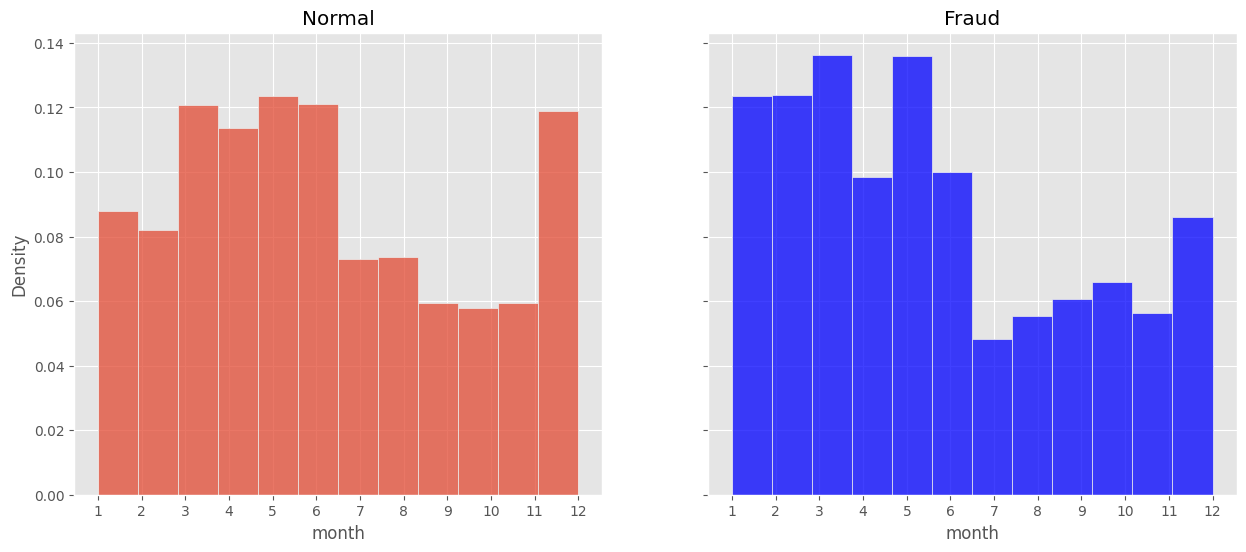

In [32]:
train['month'] = pd.to_datetime(train['trans_date_trans_time']).dt.month
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='month', data=train[train["is_fraud"] == 0],
                   stat="density", bins=12, ax=ax1)
ax2 = sns.histplot(x='month', data=train[train["is_fraud"] == 1],
                   stat="density", bins=12, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 13))
ax2.set_xticks(np.arange(1, 13));

# Feature Engineering

In [33]:
train.drop(columns=["merchant", "first", "last", "street","unix_time", "trans_num"], inplace=True)

In [34]:
train.head(2)

,trans_date_trans_time,cc_num,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,age,hour,month
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,36.01,-82.05,0,37,0,1
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,49.16,-118.19,0,47,0,1


## Scaling

<Axes: xlabel='amt_log', ylabel='Density'>

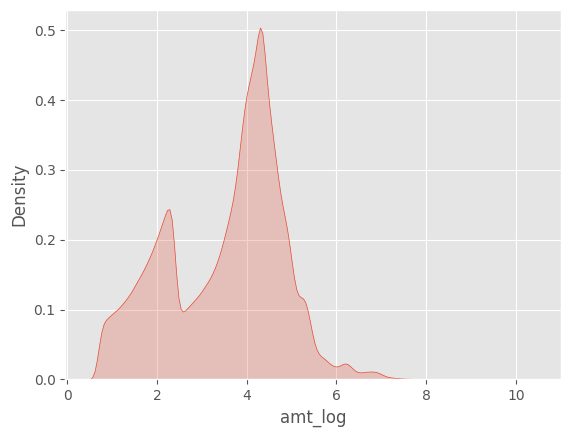

In [35]:
train["amt_log"] = np.log1p(train["amt"])
sns.kdeplot(train["amt_log"], fill=True)

In [36]:
def check_normality(feature):
    plt.figure(figsize=(8, 8))
    ax1 = plt.subplot(1, 1, 1)
    stats.probplot(train[feature], dist=stats.norm, plot=ax1)
    ax1.set_title(f'{feature} Q-Q plot', fontsize=20)
    sns.despine()

    mean = train[feature].mean()
    std = train[feature].std()
    skew = train[feature].skew()
    print(f'{feature} : mean: {mean:.2f}, std: {std:.2f}, skew: {skew:.2f}')

amt : mean: 70.35, std: 160.32, skew: 42.28


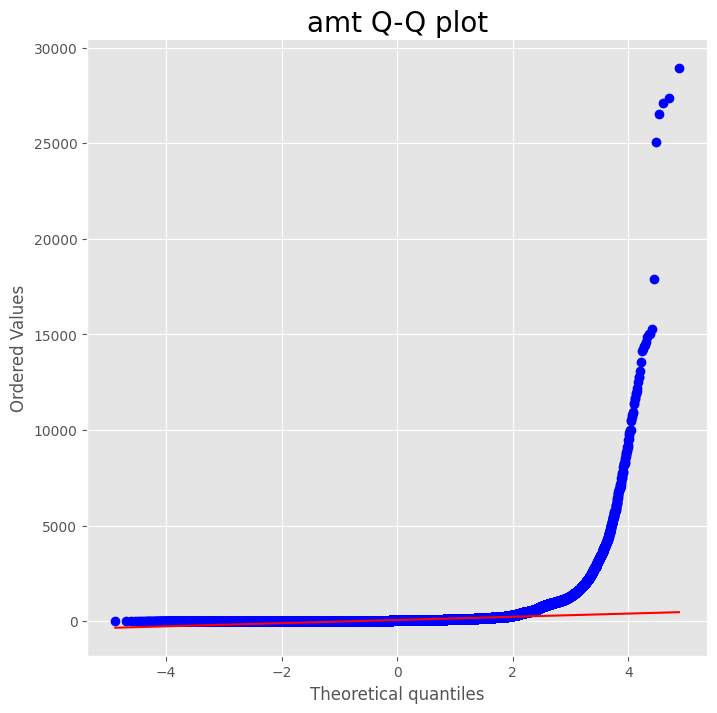

In [37]:
check_normality("amt")

amt_log : mean: 3.53, std: 1.29, skew: -0.30


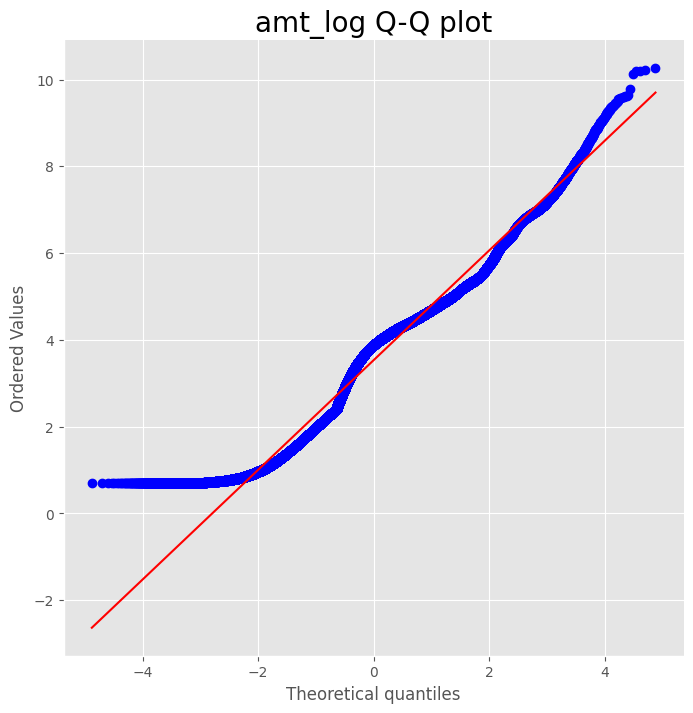

In [38]:
check_normality("amt_log")

## Categorical Encoding

In [39]:
# weight of evidence encoding
def apply_woe(train, columns, target_col):
    woe = ce.WOEEncoder()
    for col in columns:
        X = train[col]
        y = train[target_col]
        new_col_name = f"{col}_WOE"
        train[new_col_name] = woe.fit_transform(X, y)
    return train

columns_to_encode = ["category", "state", "city", "job"]
target_column = "is_fraud"

train = apply_woe(train, columns_to_encode, target_column)

In [40]:
gender_mapping = {"F": 0, "M": 1}
train["gender_binary"] = train["gender"].map(gender_mapping)

In [41]:
freq_enc = (train.groupby("cc_num").size())
freq_enc.sort_values(ascending=True)
train["cc_num_frequency"] = train["cc_num"].apply(lambda x: freq_enc[x])

<Axes: xlabel='cc_num_frequency', ylabel='Count'>

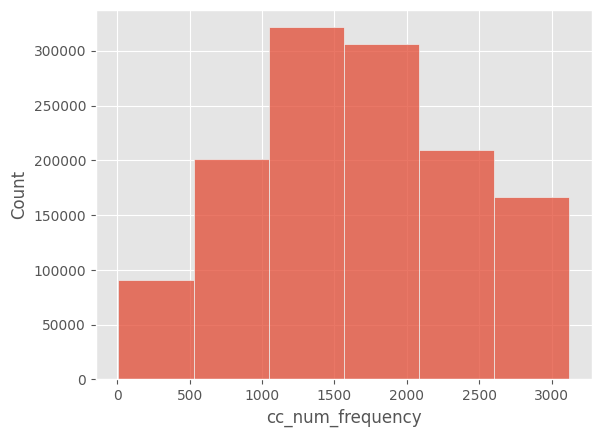

In [42]:
sns.histplot(train["cc_num_frequency"], bins=6)

In [43]:
intervals = [600, 1200, 1800, 2400, 3000, 3600]


def classify_frequency(freq):
    for i, c in enumerate(intervals):
        if freq <= c:
            return i


train["cc_num_frequency_classification"] = train["cc_num_frequency"].apply(
    classify_frequency)

Text(0.5, 1.0, 'Fraud')

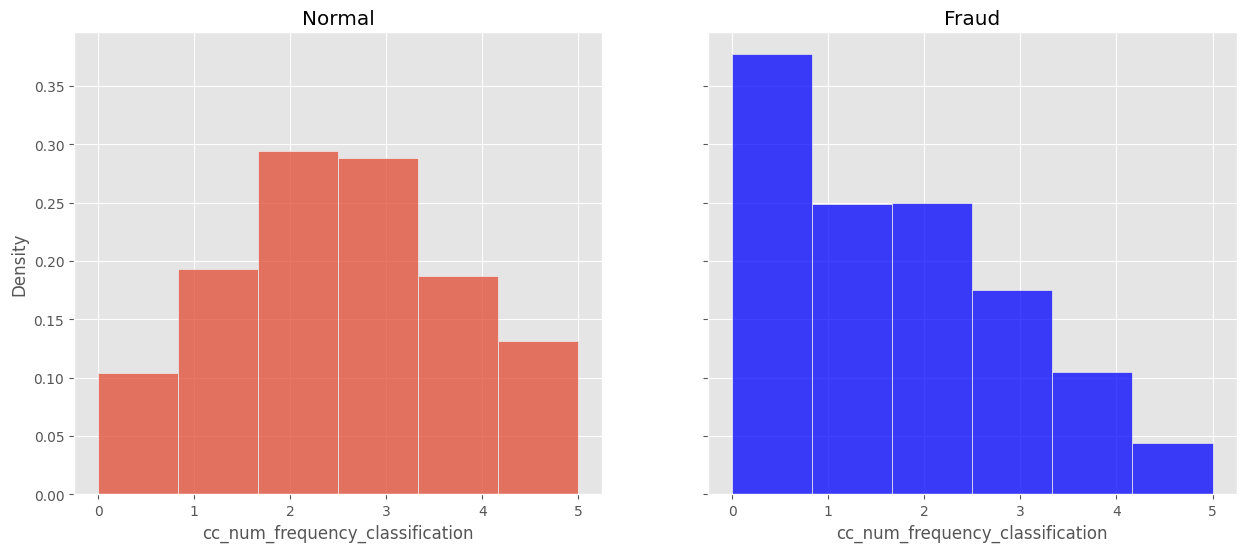

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 0],
                   stat="density", bins=6, ax=ax1)
ax2 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 1],
                   stat="density", bins=6, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")

# Undersampling

In [45]:
X = train.drop(columns=["is_fraud"])
y = train["is_fraud"]

In [46]:
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=23)

In [47]:
X_undersampled, y_undersampled = rus.fit_resample(X, y)

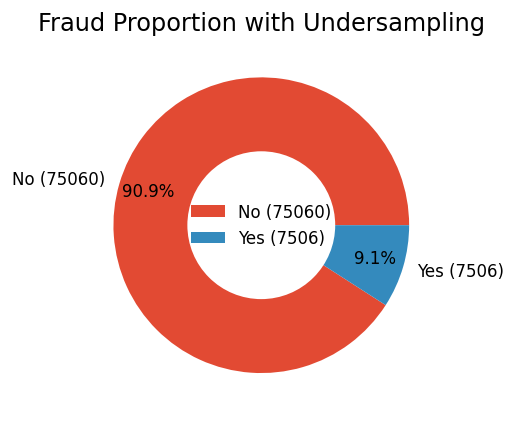

In [85]:
donut = y_undersampled.value_counts().reset_index()
donut.columns = ["is_fraud", "count"]

labels = [f"No ({donut.loc[donut['is_fraud'] == 0, 'count'].values[0]})", 
          f"Yes ({donut.loc[donut['is_fraud'] == 1, 'count'].values[0]})"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["count"], labels=labels, autopct="%1.1f%%", pctdistance=0.8, explode=explode)
centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud Proportion with Undersampling")
plt.legend(labels, loc="center", frameon=False)
plt.show()

# Feature Importance

In [50]:
X_undersampled["random_feat_1"] = np.random.randint(0, 100, size=len(X_undersampled))
X_undersampled["random_feat_2"] = np.random.randint(0, 500, size=len(X_undersampled))

In [51]:
X_train = X_undersampled.drop(columns=["trans_date_trans_time","city", "state", "category", "gender", "dob", "job", "cc_num", "amt"])
y_train = y_undersampled

In [52]:
X_train.head()

,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE,gender_binary,cc_num_frequency,cc_num_frequency_classification,random_feat_1,random_feat_2
118515,77566,29.04,-95.44,28739,29.24,-95.43,26,5,3,3.89,-0.21,-0.14,0.14,0.35,1,2556,4,36,232
598857,12460,42.41,-74.15,277,41.56,-74.09,54,7,9,4.65,0.90,0.14,0.20,0.70,1,1548,2,23,377
59238,98304,46.75,-121.99,759,46.60,-122.18,69,18,2,2.39,-0.70,-0.12,0.77,0.11,0,1040,1,53,90
710180,31042,32.81,-83.17,1841,33.09,-84.14,50,5,10,3.63,-0.61,-0.03,0.00,-0.23,1,1548,2,95,444
6204,99160,48.89,-118.21,149,48.08,-119.14,47,23,1,1.42,1.12,-0.12,-3.03,-0.90,0,3030,5,90,161


In [53]:
rf = RandomForestClassifier(random_state=23, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=999)
result_boruta = feat_selector.fit(X_train.values, y_train)
accept = X_train.columns[feat_selector.support_].to_list()
irresolution = X_train.columns[feat_selector.support_weak_].to_list()

print("Features selected:")
list(accept)

Features selected:


['zip',
 'lat',
 'long',
 'city_pop',
 'merch_lat',
 'merch_long',
 'age',
 'hour',
 'month',
 'amt_log',
 'category_WOE',
 'state_WOE',
 'city_WOE',
 'job_WOE',
 'gender_binary',
 'cc_num_frequency',
 'cc_num_frequency_classification']

In [55]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
importances = rf.feature_importances_

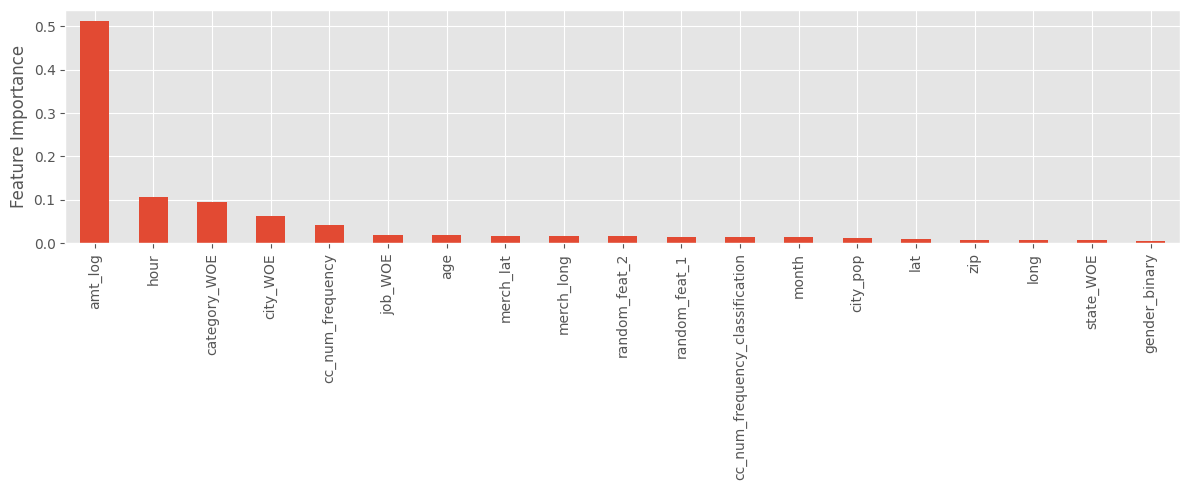

In [57]:
forest_importances = pd.Series(importances, index=X_train.columns)
fig, ax = plt.subplots(figsize=(12, 5))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_ylabel("Feature Importance")
fig.tight_layout()

In [59]:
X_train.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat","city_pop", "month", "cc_num_frequency_classification","random_feat_1", "random_feat_2", "merch_long"], inplace=True)

In [60]:
X_train.head()

,merch_lat,age,hour,amt_log,category_WOE,city_WOE,job_WOE,cc_num_frequency
118515,29.24,26,5,3.89,-0.21,0.14,0.35,2556
598857,41.56,54,7,4.65,0.90,0.20,0.70,1548
59238,46.60,69,18,2.39,-0.70,0.77,0.11,1040
710180,33.09,50,5,3.63,-0.61,0.00,-0.23,1548
6204,48.08,47,23,1.42,1.12,-3.03,-0.90,3030


# Preparing test data

In [61]:
test = pd.read_csv("fraudTest.csv", index_col=0)

test['age'] = dt.date.today().year-pd.to_datetime(test['dob']).dt.year
test['hour'] = pd.to_datetime(test['trans_date_trans_time']).dt.hour
test['month'] = pd.to_datetime(test['trans_date_trans_time']).dt.month

test.drop(columns=["merchant", "first", "last", "street","unix_time", "trans_num"], inplace=True)

test["amt_log"] = np.log1p(test["amt"])

test = apply_woe(test, columns_to_encode, target_column)

test["gender_binary"] = test["gender"].map(gender_mapping)

freq_enc_test = (test.groupby("cc_num").size())
freq_enc_test.sort_values(ascending=True)
test["cc_num_frequency"] = test["cc_num"].apply(lambda x: freq_enc_test[x])
test["cc_num_frequency_classification"] = test["cc_num_frequency"].apply(classify_frequency)

X_test = test.drop(columns=["trans_date_trans_time","city", "state", "category", "gender", "dob", "job", "cc_num", "amt", "is_fraud"])

y_test = test["is_fraud"]

X_test.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat","city_pop", "month", "cc_num_frequency_classification", "merch_long"], inplace=True)

# Training the model

In [70]:
def evaluate_model(target, predicted, y_score, normalize_matrix= None):
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)
    confusion_matrix = metrics.confusion_matrix(target, predicted, normalize=normalize_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    fpr, tpr, threshold = roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print("Accuracy:", round(accuracy, 2))
    print("Precision:", round(precision, 2))
    print("Recall:", round(recall, 2))
    print("F1 Score", round(f1, 2))
    print("AUC:", auc)
    return None

In [64]:
rf = RandomForestClassifier(random_state=23)
knn = KNeighborsClassifier()
gboost = GradientBoostingClassifier(random_state=23)
lr=LogisticRegression(random_state=23)
dt = DecisionTreeClassifier(random_state=23)

In [65]:
#random forest

rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_score_train = rf.predict_proba(X_train)[:,1]

y_pred_test = rf.predict(X_test)
y_score_test = rf.predict_proba(X_test)[:,1]

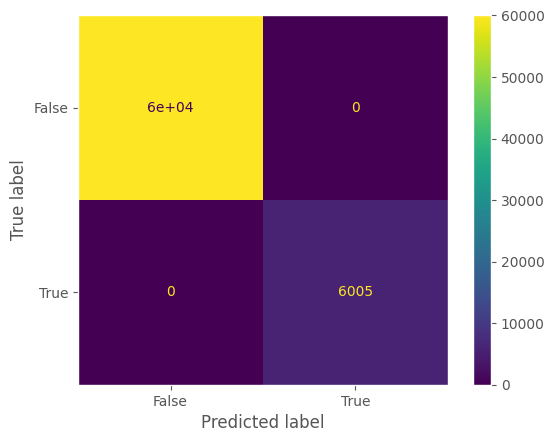

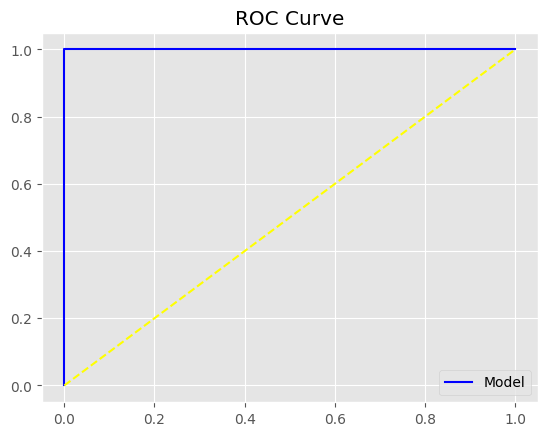

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0
AUC: 1.0


In [71]:
evaluate_model(y_train, y_pred_train, y_score_train)

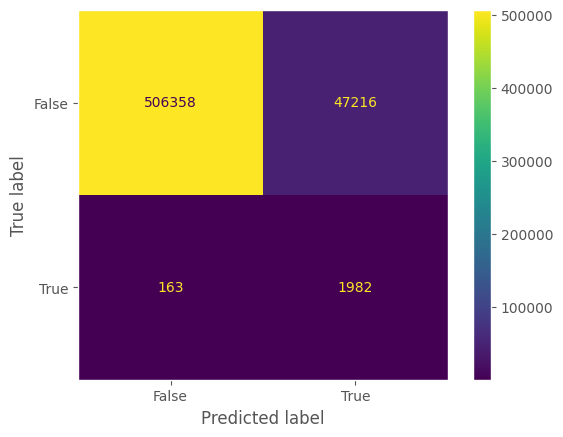

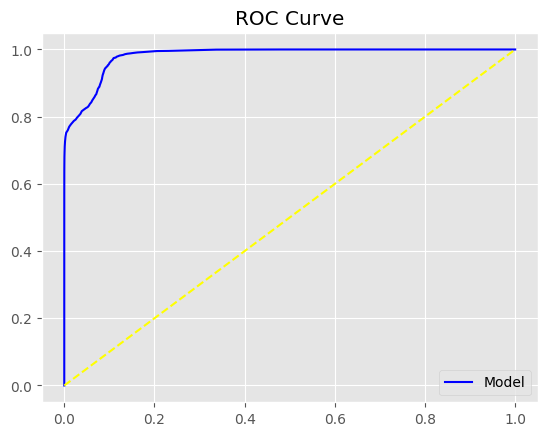

Accuracy: 0.91
Precision: 0.04
Recall: 0.92
F1 Score 0.08
AUC: 0.9820316465608695


In [72]:
evaluate_model(y_test, y_pred_test, y_score_test)

In [73]:
#knn

knn.fit(X_train, y_train)

y_pred_train = knn.predict(X_train)
y_score_train = knn.predict_proba(X_train)[:,1]

y_pred_test = knn.predict(X_test)
y_score_test = knn.predict_proba(X_test)[:,1]

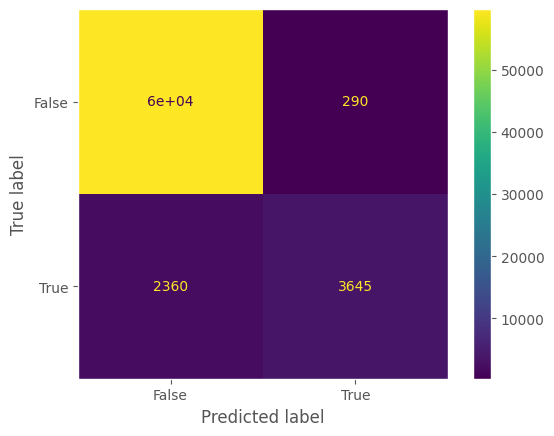

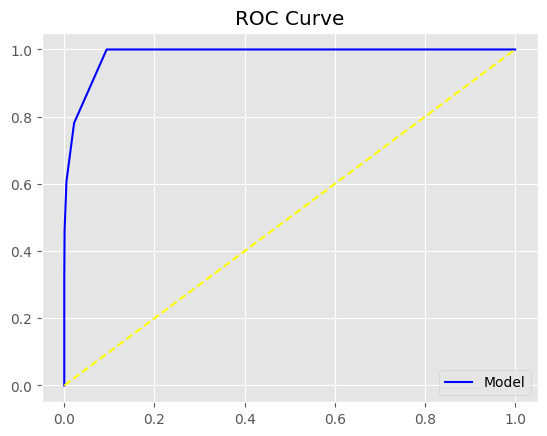

Accuracy: 0.96
Precision: 0.93
Recall: 0.61
F1 Score 0.73
AUC: 0.9845539783733384


In [74]:
evaluate_model(y_train, y_pred_train, y_score_train)

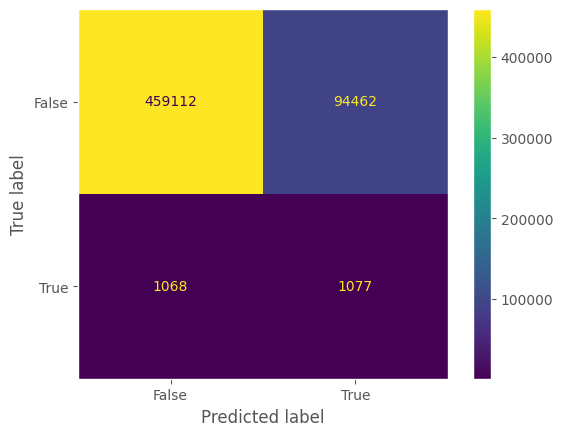

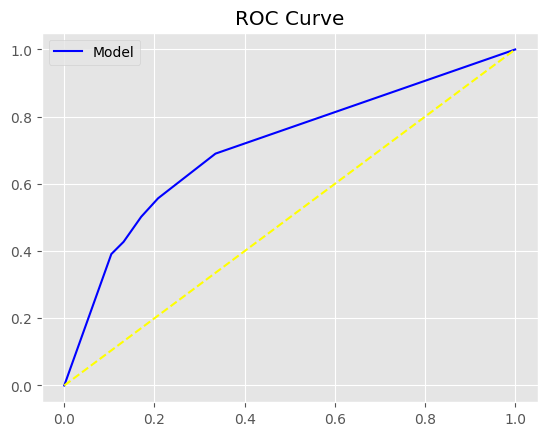

Accuracy: 0.83
Precision: 0.01
Recall: 0.5
F1 Score 0.02
AUC: 0.7105291423378979


In [75]:
evaluate_model(y_test, y_pred_test, y_score_test)

In [76]:
#gradient boosting

gboost.fit(X_train, y_train)

y_pred_train = gboost.predict(X_train)
y_score_train = gboost.predict_proba(X_train)[:,1]

y_pred_test = gboost.predict(X_test)
y_score_test = gboost.predict_proba(X_test)[:,1]

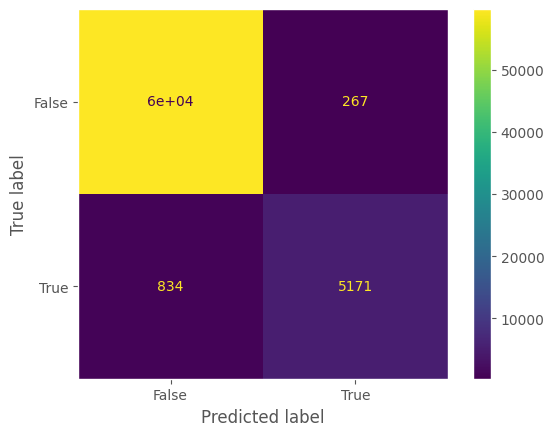

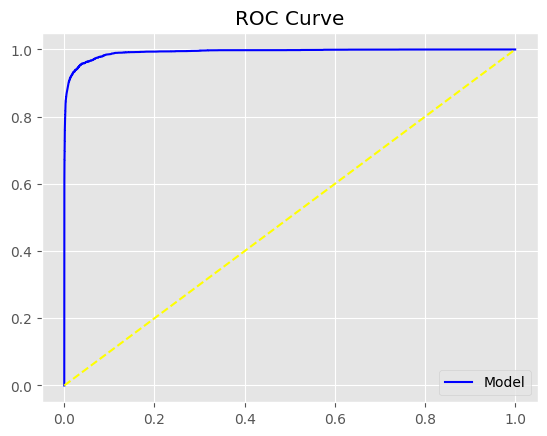

Accuracy: 0.98
Precision: 0.95
Recall: 0.86
F1 Score 0.9
AUC: 0.9928558918050968


In [77]:
evaluate_model(y_train, y_pred_train, y_score_train)

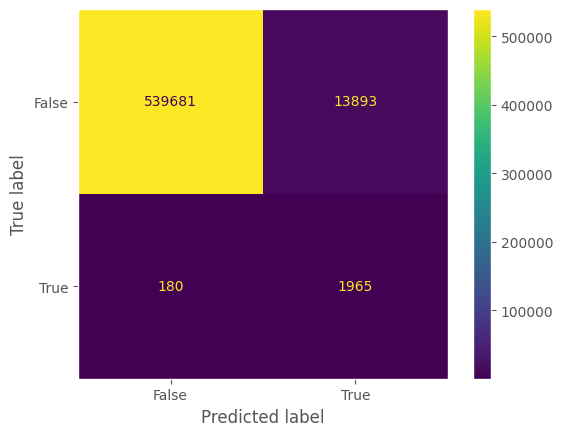

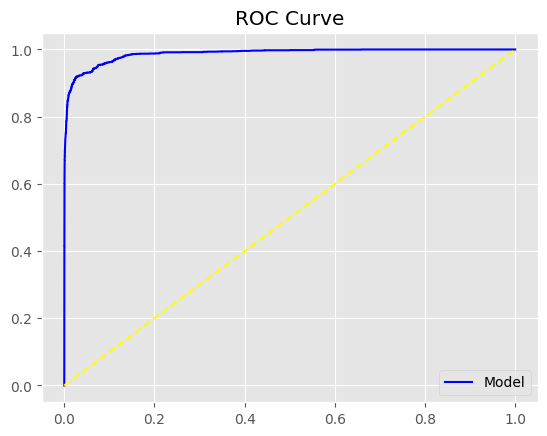

Accuracy: 0.97
Precision: 0.12
Recall: 0.92
F1 Score 0.22
AUC: 0.9878040188148683


In [78]:
evaluate_model(y_test, y_pred_test, y_score_test)

In [79]:
# linear regression

lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_score_train = lr.predict_proba(X_train)[:,1]

y_pred_test = lr.predict(X_test)
y_score_test = lr.predict_proba(X_test)[:,1]

c:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


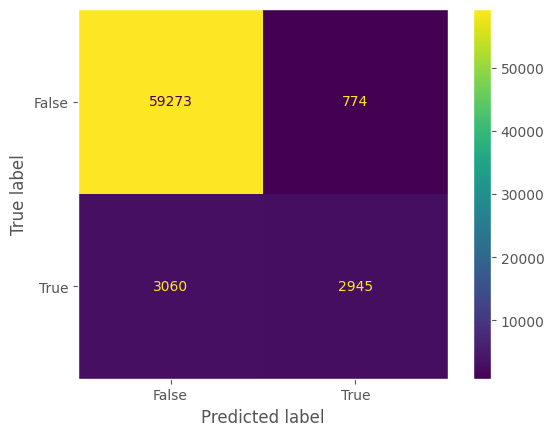

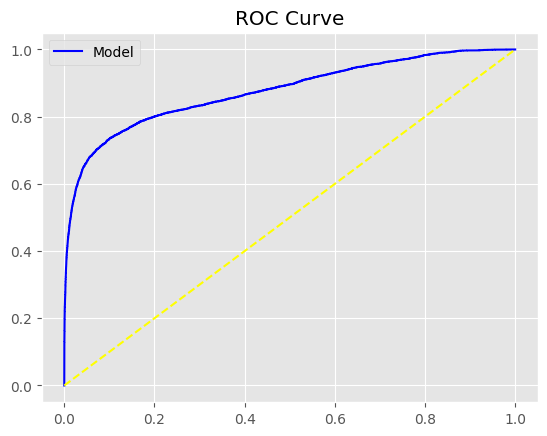

Accuracy: 0.94
Precision: 0.79
Recall: 0.49
F1 Score 0.61
AUC: 0.8761364796576846


In [80]:
evaluate_model(y_train, y_pred_train, y_score_train)

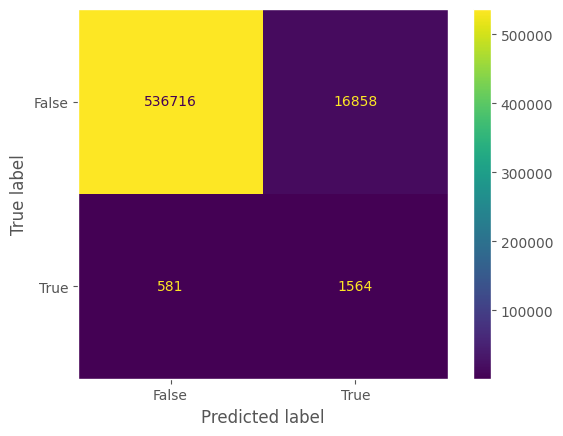

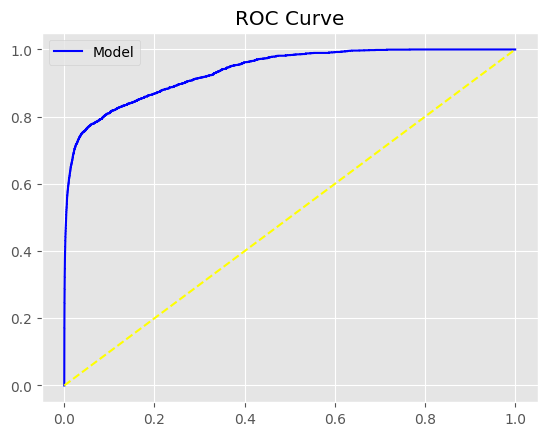

Accuracy: 0.97
Precision: 0.08
Recall: 0.73
F1 Score 0.15
AUC: 0.9361327518657885


In [81]:
evaluate_model(y_test, y_pred_test, y_score_test)

In [82]:
#decision tree

dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_score_train = dt.predict_proba(X_train)[:,1]

y_pred_test = dt.predict(X_test)
y_score_test = dt.predict_proba(X_test)[:,1]

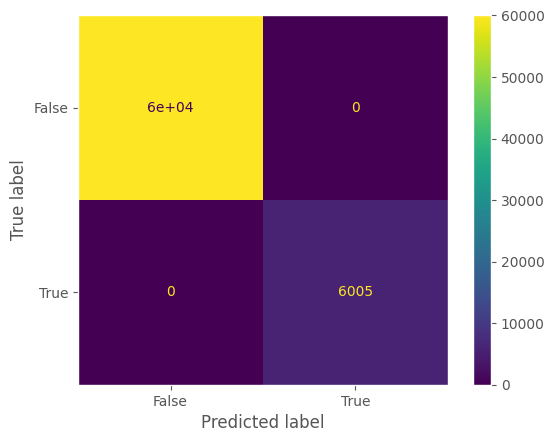

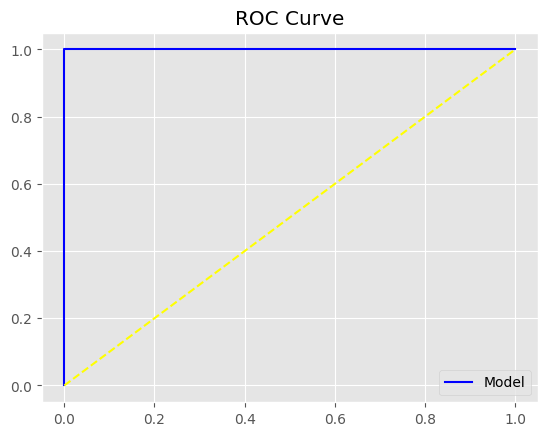

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0
AUC: 1.0


In [83]:
evaluate_model(y_train, y_pred_train, y_score_train)

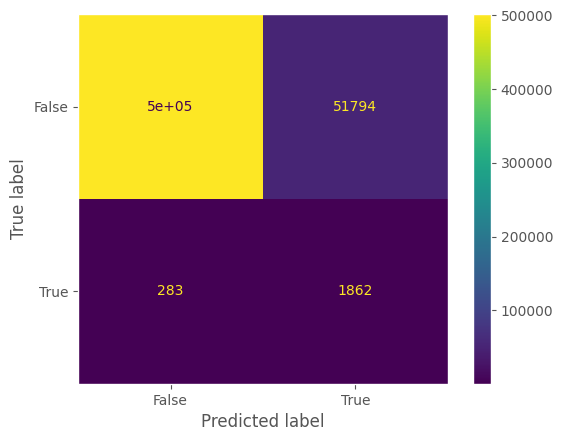

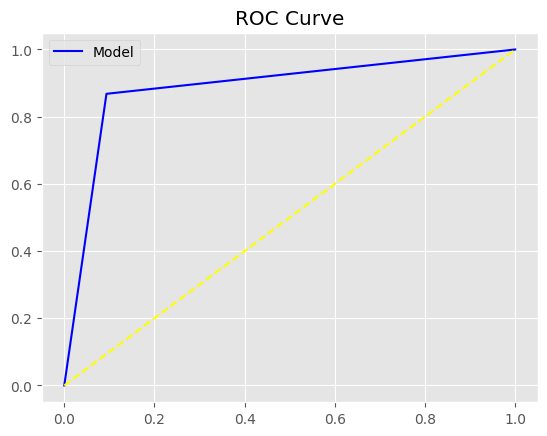

Accuracy: 0.91
Precision: 0.03
Recall: 0.87
F1 Score 0.07
AUC: 0.8872511739207067


In [84]:
evaluate_model(y_test, y_pred_test, y_score_test)